# Poincare Map

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/cchu/Desktop/phd_work/hyperChromatin/src/PoincareMaps')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os
workdir = '../results/02'
os.makedirs(workdir, exist_ok=True)


In [127]:
import scanpy as sc
import pandas as pd
import numpy as np
from refs import celltype_colors
import matplotlib.pyplot as plt
from IPython.display import Image

from main import *
from poincare_maps import *

# Setup data

In [58]:
adata_CG_fn = '../results/00/rna_annot.h5ad'
adata_CP_fn = '../results/00/atac_annot.h5ad'

adata_CG = sc.read_h5ad(adata_CG_fn)
adata_CP = sc.read_h5ad(adata_CP_fn)

# RNA only

## PCA

In [60]:
adata_CG_df = pd.DataFrame(
    np.concatenate([adata_CG.obsm['X_pca'], adata_CG.obs['celltype'].values.reshape(-1, 1)], axis=1)
).rename(columns={adata_CG.obsm['X_pca'].shape[1]: 'labels'}) # rename last column to 'labels'
adata_CG_df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,labels
0,2.367957,-6.071699,2.237952,-1.245867,0.250824,-1.930032,-2.915433,-0.290758,-0.64471,0.598724,...,0.939159,0.721108,-1.676134,-2.140087,0.251133,-0.319847,-1.41207,-0.595178,-0.889735,TAC-1
1,7.887315,-5.54415,3.007106,-1.200632,0.985795,-1.118838,-6.048435,0.006853,0.589192,1.867252,...,1.427872,-0.015054,0.329807,0.455322,1.096687,1.309756,-0.535346,0.752211,-0.259502,TAC-1
2,0.527384,-0.651163,-0.874278,0.170479,1.542949,3.470287,-2.910914,-2.125489,-0.02936,1.404289,...,-2.322264,0.380071,-1.523124,2.020876,-1.907275,1.174181,2.218176,0.363034,-1.413814,TAC-1
3,4.125784,-4.18372,3.485001,0.280632,-0.940388,0.248494,-3.448356,5.180751,-0.81208,-0.398455,...,-0.457325,-1.17518,0.395827,-1.277887,-0.347039,-1.491612,0.805422,-0.976794,1.278971,TAC-1
4,2.878132,-1.901465,-3.51077,2.379621,-1.982147,-0.008846,1.320532,3.189339,0.095299,2.223668,...,0.89798,-0.166548,0.317924,0.973922,0.024081,-0.629385,0.148933,-0.084616,1.70386,TAC-1


In [61]:
adata_CG_df_fn = f'{workdir}/rna_pca.celltype_label.csv'
print(adata_CG_df_fn)
adata_CG_df.to_csv(adata_CG_df_fn, index=False, sep=',')

../results/02/rna_pca.celltype_label.csv


In [62]:
CG_features, CG_labels = prepare_data('../results/02/rna_pca.celltype_label', 
                                with_labels=True, 
                                normalize=True, 
                                n_pca=0)

In [64]:
CG_poincare_coord, _ = compute_poincare_maps(CG_features, CG_labels,
                        f"{workdir}/rna_pca.celltype_label.poincare_coord",
                        mode='features', k_neighbours=15, 
                        distlocal='minkowski', sigma=1.0, gamma=2.0,
                        color_dict=celltype_colors, epochs=100,
                        batchsize=-1, lr=0.1, earlystop=0.0001, cuda=0)

Computing laplacian...
Laplacian computed in 2.77 sec
Computing RFA...
RFA computed in 3.94 sec
batchsize =  512
Starting training...


loss: 0.50211: 100%|██████████████████████████| 100/100 [17:16<00:00, 10.36s/it]


PM computed in 1036.46 sec
loss = 5.021e-01
time = 17.277 min


In [111]:
CG_poincare_coord_df = pd.DataFrame(np.concatenate([CG_poincare_coord, CG_labels.reshape(-1, 1)], axis=1))
CG_poincare_coord_df.columns = ['x', 'y', 'labels']
CG_poincare_coord_df.head()

,x,y,labels
0,-0.019778899301862145,-0.05066239306123151,TAC-1
1,-0.052852075541215265,-0.03277250736476505,TAC-1
2,0.025417964769202255,0.040444612570345886,TAC-1
3,-0.04858368357698109,-0.0344286664478931,TAC-1
4,-0.023558211179936495,0.024753878568053608,TAC-1


In [112]:
CG_poincare_coord_fn = f'{workdir}/rna_pca.celltype_label.poincare_coord.labeled.csv'
print(CG_poincare_coord_fn)
CG_poincare_coord_df.to_csv(CG_poincare_coord_fn, index=False, sep=',')

../results/02/rna_pca.celltype_label.poincare_coord.labeled.csv


In [65]:
rna_model = PoincareMaps(CG_poincare_coord)


In [125]:
rna_model.plot('ori', labels=CG_labels, file_name=f'{workdir}/rna_pca.celltype_label.poincare_coord', 
           title_name='Poincaré map', 
           coldict=celltype_colors, 
           labels_order=None, 
           zoom=4, bbox=(1.1, 0.8), leg=False, ft='png')

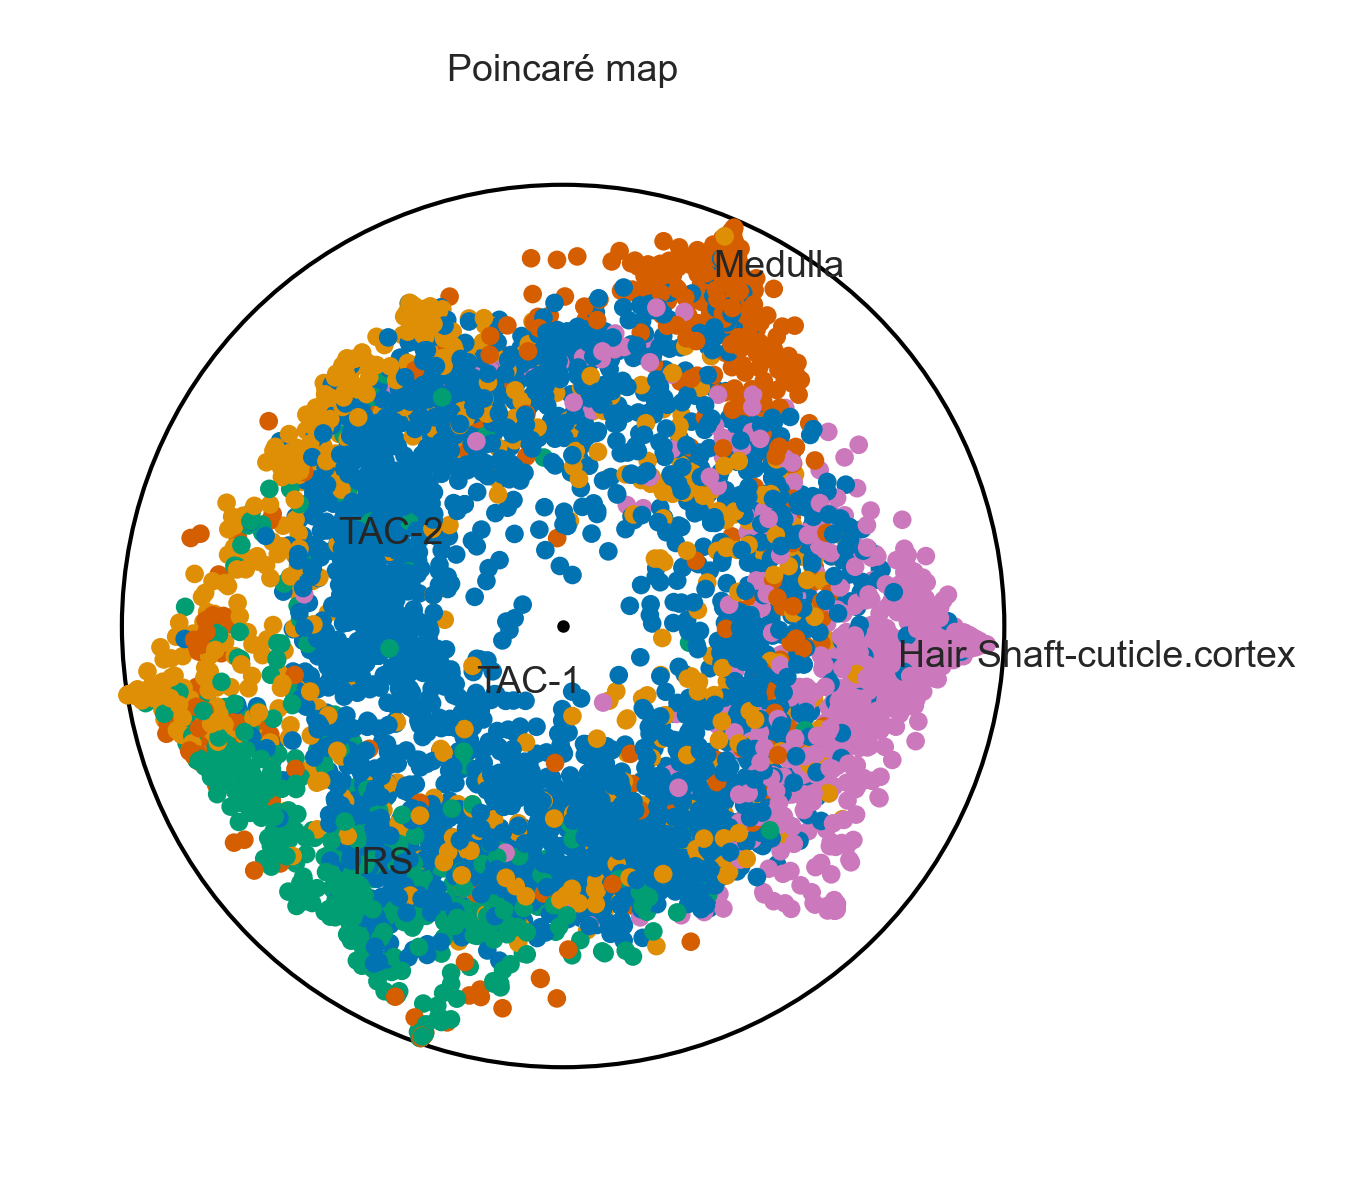

In [128]:
fig = Image(filename=f'{workdir}/rna_pca.celltype_label.poincare_coord.png')
fig


## SIMBA RNA

In [79]:
simba_rna_fn = "../results/01/simba_CG_adata_C.h5ad"
simba_rna_adata = sc.read_h5ad(simba_rna_fn)

In [85]:
simba_rna_adata.obs['celltype'].values.reshape(-1, 1).shape

(6436, 1)

In [88]:
simba_rna_df = pd.DataFrame(
    np.concatenate([simba_rna_adata.X, simba_rna_adata.obs['celltype'].values.reshape(-1, 1)], axis=1)
).rename(columns={simba_rna_adata.X.shape[1]: 'labels'})
simba_rna_df.head()


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,labels
0,-0.389552,0.413746,-0.165793,-0.141191,-0.023034,0.086013,-0.259419,0.010679,-0.049745,-0.111304,...,0.116075,-0.445225,-0.214517,-0.421019,-0.219081,0.046853,0.091314,0.077687,0.193099,TAC-2
1,0.182545,-0.12032,0.2202,-0.263891,0.143113,-0.115181,-0.403139,-0.023173,0.018975,0.05114,...,0.258667,-0.063164,-0.092172,0.09501,-0.277419,0.094471,0.128283,-0.21548,0.113008,Medulla
2,0.35713,0.225384,-0.015943,-0.308319,-0.01214,-0.009785,-0.533384,-0.038851,-0.127569,-0.040765,...,0.306368,-0.13116,-0.408849,-0.277945,-0.42584,0.081465,0.282202,-0.153752,0.041669,TAC-2
3,-0.018473,0.100568,0.080207,-0.432236,0.195109,-0.379287,-0.335688,-0.031777,0.144556,0.088513,...,0.665376,-0.198587,-0.450813,-0.008082,-0.11462,0.276493,0.146646,0.129647,0.182428,Medulla
4,-0.102362,0.372987,-0.247467,-0.201401,-0.116746,0.183989,-0.319577,-0.020873,0.232875,0.042379,...,0.473882,-0.119188,-0.097014,-0.169521,-0.405905,-0.240587,0.32216,0.141584,0.512228,TAC-1


In [89]:
simba_rna_df_fn = f'{workdir}/rna_simba.celltype_label.csv'
print(simba_rna_df_fn)
simba_rna_df.to_csv(simba_rna_df_fn, index=False, sep=',')

../results/02/simba_rna_pca.celltype_label.csv


In [90]:
simba_rna_features, simba_rna_labels = prepare_data(
    '../results/02/rna_simba.celltype_label', 
    with_labels=True, 
    normalize=True, 
    n_pca=0
)

In [92]:
simba_rna_poincare_coord, _ = compute_poincare_maps(simba_rna_features, simba_rna_labels,
                        f"{workdir}/rna_simba.celltype_label.poincare_coord",
                        mode='features', k_neighbours=15, 
                        distlocal='minkowski', sigma=1.0, gamma=2.0,
                        color_dict=celltype_colors, epochs=100,
                        batchsize=-1, lr=0.1, earlystop=0.0001, cuda=0)

Computing laplacian...
Laplacian computed in 2.72 sec
Computing RFA...
RFA computed in 5.16 sec
batchsize =  512
Starting training...


loss: 0.64894: 100%|██████████████████████████| 100/100 [17:02<00:00, 10.22s/it]

PM computed in 1022.37 sec
loss = 6.489e-01
time = 17.042 min


In [108]:
simba_rna_poincare_coord_df = pd.DataFrame(np.concatenate([simba_rna_poincare_coord, simba_rna_labels.reshape(-1, 1)], axis=1))
simba_rna_poincare_coord_df.columns = ['x', 'y', 'labels']
simba_rna_poincare_coord_df.head()

,x,y,labels
0,-0.11833885944488218,0.22942112691696837,TAC-2
1,0.21190599939817867,-0.25137563494327664,Medulla
2,0.2676294020577761,-0.27157255158503973,TAC-2
3,-0.242792944702911,-0.3575752791969172,Medulla
4,-0.26255979009946584,0.1982134458793874,TAC-1


In [109]:
simba_rna_poincare_coord_fn = f'{workdir}/rna_simba.celltype_label.poincare_coord.labeled.csv'
print(simba_rna_poincare_coord_fn)
simba_rna_poincare_coord_df.to_csv(simba_rna_poincare_coord_fn, index=False, sep=',')

../results/02/rna_simba.celltype_label.poincare_coord.labeled.csv


In [124]:
simba_rna_model = PoincareMaps(simba_rna_poincare_coord)
simba_rna_model.plot('ori', labels=simba_rna_labels, file_name=f'{workdir}/rna_simba.celltype_label.poincare_coord', 
           title_name='Poincaré map', 
           coldict=celltype_colors, 
           labels_order=None, 
           zoom=1, bbox=(1.1, 0.8), leg=False, ft='png')

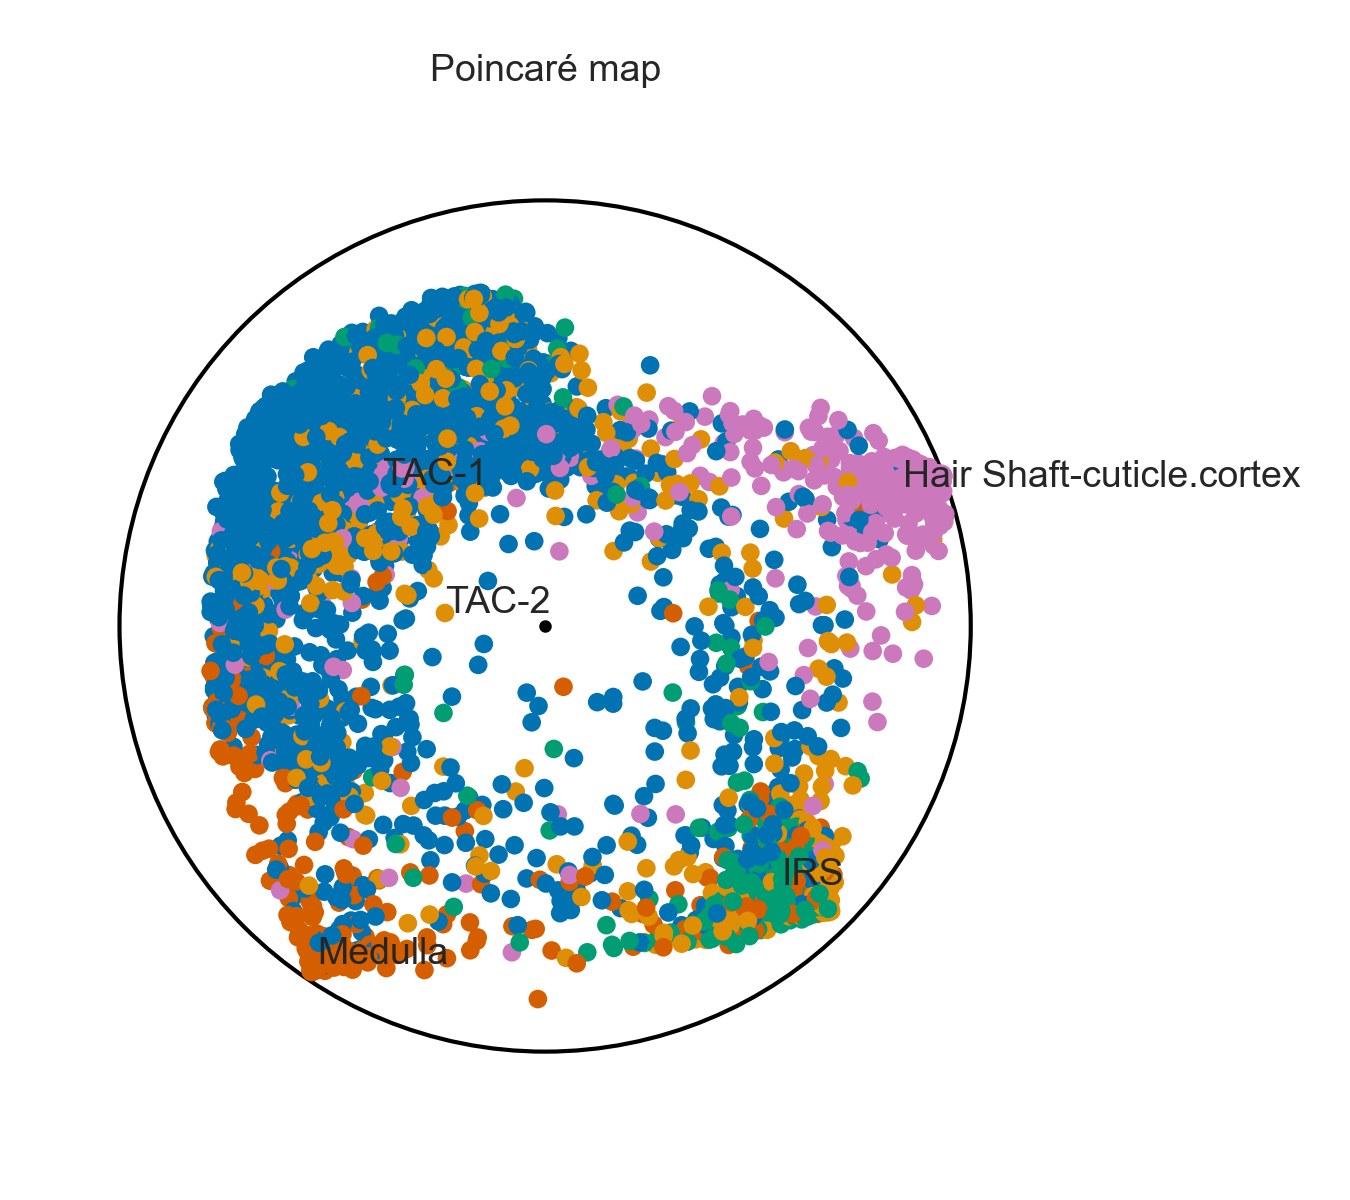

In [129]:
fig = Image(filename=f'{workdir}/rna_simba.celltype_label.poincare_coord.png')
fig


# ATAC PCA only

In [28]:
adata_CP_df = pd.DataFrame(
    np.concatenate([adata_CP.obsm['X_pca'], adata_CP.obs['celltype'].values.reshape(-1, 1)], axis=1)
).rename(columns={adata_CP.obsm['X_pca'].shape[1]: 'labels'}) # rename last column to 'labels'
adata_CP_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,21.069725,-2.105259,0.426905,0.394971,0.13392,3.240892,-0.362018,0.38208,-0.287501,0.327524,...,0.292555,-0.0219,-0.080205,-0.920582,0.414664,-0.025258,-0.636701,0.115593,-0.757653,TAC-1
1,36.54454,-4.505837,2.230981,0.91011,0.653825,7.49185,-1.603396,-0.277394,-0.729834,0.329741,...,2.038323,-0.452311,-0.268561,-1.422866,1.805654,-0.333632,-3.193193,-0.91992,1.093912,TAC-1
2,34.493877,0.257381,0.293227,0.956851,0.500575,1.748897,-0.711508,1.013071,0.513619,1.374203,...,0.590484,0.297129,-0.391208,-0.483023,-0.059557,-0.151057,0.211194,-1.745793,0.62902,TAC-1
3,23.649405,-2.205518,0.710609,0.803702,0.516655,3.900526,-0.827967,-0.250073,-0.029885,0.039449,...,1.368556,0.076479,-0.317342,-1.151389,0.625196,-0.009191,-1.440018,-0.520667,1.393873,TAC-1
4,20.654346,-1.877955,0.340343,0.079938,-0.567403,2.000677,-0.354367,2.006757,0.717302,1.724177,...,-0.262928,-0.253518,0.761159,0.515671,-0.162613,0.25653,-0.28814,-0.000501,-0.272529,TAC-1


In [30]:
adata_CP_df_fn = f'{workdir}/atac_pca.celltype_label.csv'
print(adata_CP_df_fn)
adata_CP_df.to_csv(adata_CP_df_fn, index=False, sep=',')

../results/02/atac_pca.celltype_label.csv


In [31]:
CP_features, CP_labels = prepare_data('../results/02/atac_pca.celltype_label', 
                                with_labels=True, 
                                normalize=True, 
                                n_pca=0)

In [50]:
CP_poincare_coord, _ = compute_poincare_maps(CP_features, CP_labels,
                        f"{workdir}/atac_pca.celltype_label.poincare_coord",
                        mode='features', k_neighbours=15, 
                        distlocal='minkowski', sigma=1.0, gamma=2.0,
                        color_dict=celltype_colors, epochs=1000,
                        batchsize=-1, lr=0.1, earlystop=0.0001, cuda=0)

Computing laplacian...
Laplacian computed in 2.70 sec
Computing RFA...
RFA computed in 4.07 sec
batchsize =  512
Starting training...


loss: 0.52126: 100%|██████████████████████████| 100/100 [16:03<00:00,  9.63s/it]


PM computed in 963.13 sec
loss = 5.213e-01
time = 16.056 min


In [106]:
CP_poincare_coord_df = pd.DataFrame(np.concatenate([CP_poincare_coord, CP_labels.reshape(-1, 1)], axis=1))
CP_poincare_coord_df.columns = ['x', 'y', 'labels']
CP_poincare_coord_df.head()

,x,y,labels
0,-0.2742248011003625,-0.02536800849071007,TAC-1
1,-0.29886703980504975,-0.006026132667400342,TAC-1
2,-0.07365577345082051,0.08606408600137698,TAC-1
3,-0.28468824712154833,0.015857566702670824,TAC-1
4,-0.0789400634717807,-0.24462100700501271,TAC-1


In [107]:
CP_poincare_coord_fn = f'{workdir}/atac_pca.celltype_label.poincare_coord.labeled.csv'
print(CP_poincare_coord_fn)
CP_poincare_coord_df.to_csv(CP_poincare_coord_fn, index=False, sep=',')

../results/02/atac_pca.celltype_label.poincare_coord.labeled.csv


In [76]:
model = PoincareMaps(CP_poincare_coord)


In [123]:
model.plot('ori', labels=CP_labels, file_name='../results/02/atac_pca.celltype_label.poincare_coord', 
           title_name='Poincaré map', 
           coldict=celltype_colors, 
           labels_order=None, 
           zoom=2, bbox=(1.1, 0.8), leg=False, ft='png')


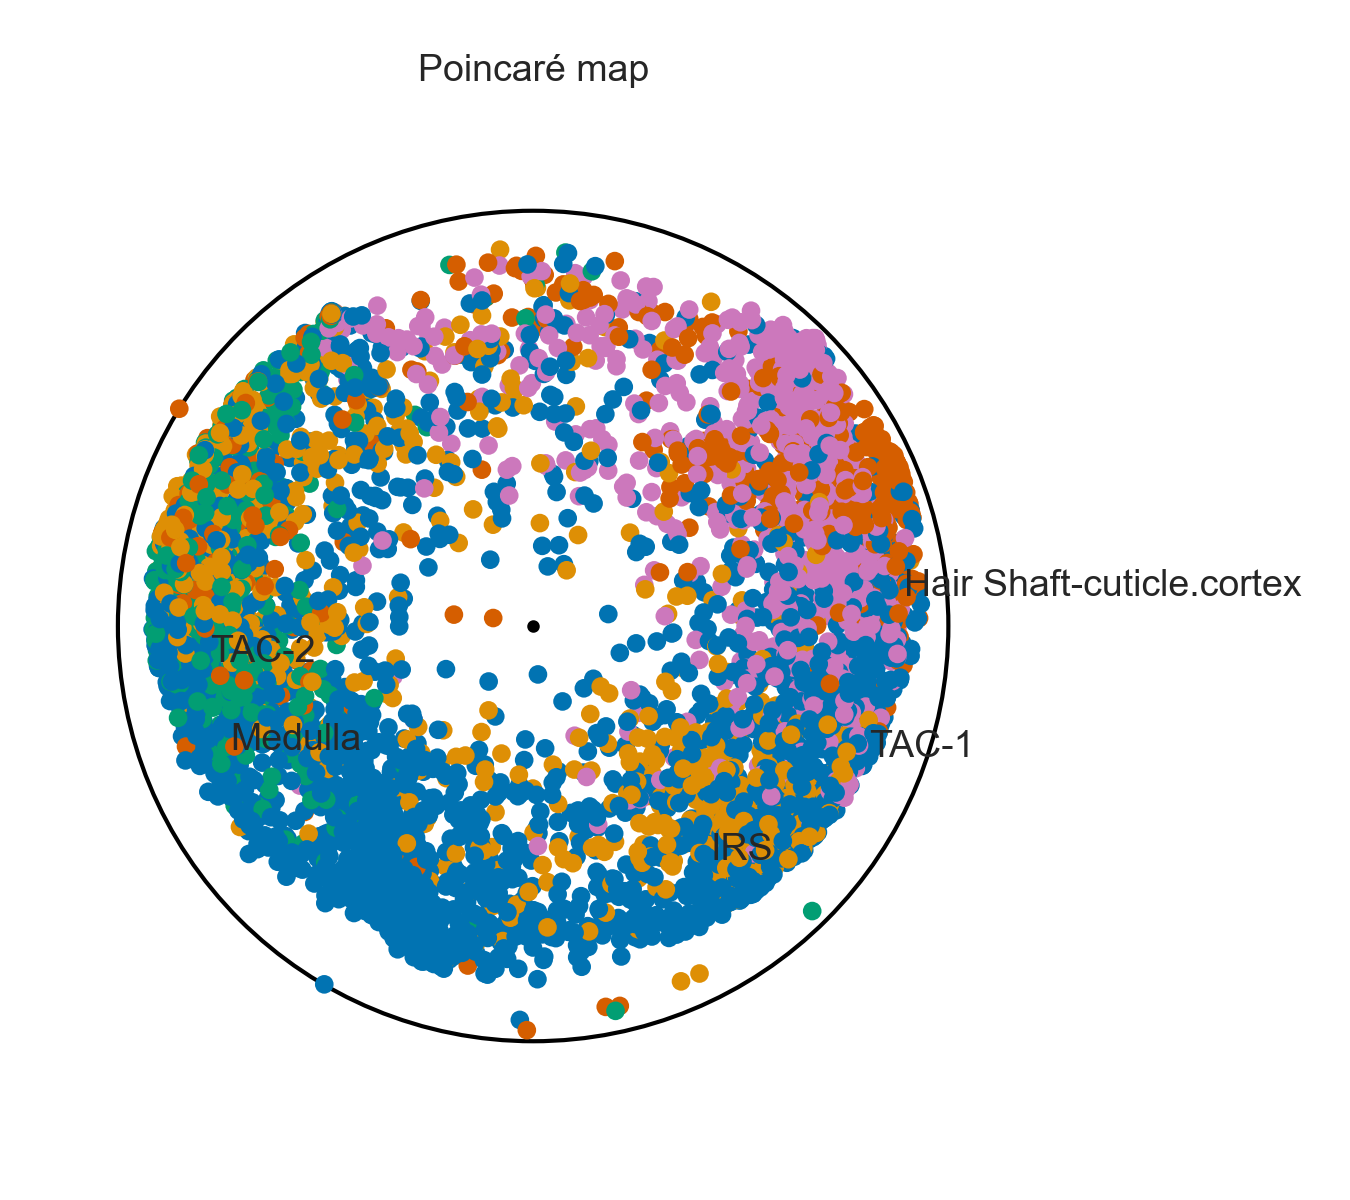

In [130]:
fig = Image(filename=f'{workdir}/atac_pca.celltype_label.poincare_coord.png')
fig


## SIMBA ATAC

In [96]:
simba_atac_fn = "../results/01/simba_CP_adata_C.h5ad"
simba_atac_adata = sc.read_h5ad(simba_atac_fn)

In [97]:
simba_atac_df = pd.DataFrame(
    np.concatenate([simba_atac_adata.X, simba_atac_adata.obs['celltype'].values.reshape(-1, 1)], axis=1)
).rename(columns={simba_atac_adata.X.shape[1]: 'labels'})
simba_atac_df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,labels
0,0.01982,0.035913,-0.423191,0.293186,-0.542922,-0.487972,0.062335,-0.190019,-0.266959,-0.088454,...,0.272543,-0.727852,-1.051891,0.22936,0.126618,-0.122738,0.204651,-0.601847,-0.170451,TAC-2
1,0.014057,-0.129721,-0.499808,-0.270405,-0.361446,-0.223808,0.419412,1.304802,-0.161319,0.244161,...,-0.191916,0.261456,-0.679568,0.054748,-0.148465,0.10389,0.191497,-0.213773,-0.1611,Medulla
2,-0.425803,0.483923,-0.402552,-0.000712,-0.194267,0.270788,-0.284302,-0.00189,-0.446223,0.064989,...,-0.252704,-0.221871,-0.662499,0.730564,0.342679,-0.139886,0.274826,-0.114894,-0.411699,IRS
3,0.480889,-0.315148,0.049132,-1.178564,-0.066195,-0.315187,0.080897,-0.778065,0.190042,0.110779,...,0.089051,-0.27475,-0.978372,0.319018,-0.171087,-0.130507,0.002961,0.287103,-0.125505,TAC-1
4,-0.159587,-0.084377,-0.092774,0.57463,0.393248,-0.546923,0.472936,0.870568,0.344172,-0.119732,...,1.038097,0.098082,-0.750161,0.101039,-0.500774,0.57473,-0.66791,0.656036,0.444685,Hair Shaft-cuticle.cortex


In [98]:
simba_atac_df_fn = f'{workdir}/atac_simba.celltype_label.csv'
print(simba_atac_df_fn)
simba_atac_df.to_csv(simba_atac_df_fn, index=False, sep=',')

../results/02/simba_atac_pca.celltype_label.csv


In [99]:
simba_atac_features, simba_atac_labels = prepare_data(
    '../results/02/atac_simba.celltype_label', 
    with_labels=True, 
    normalize=True, 
    n_pca=0
)

In [100]:
simba_atac_poincare_coord, _ = compute_poincare_maps(simba_atac_features, simba_atac_labels,
                        f"{workdir}/atac_simba.celltype_label.poincare_coord",
                        mode='features', k_neighbours=15, 
                        distlocal='minkowski', sigma=1.0, gamma=2.0,
                        color_dict=celltype_colors, epochs=100,
                        batchsize=-1, lr=0.1, earlystop=0.0001, cuda=0)

Computing laplacian...
Laplacian computed in 2.99 sec
Computing RFA...
RFA computed in 4.01 sec
batchsize =  512
Starting training...


loss: 0.44094: 100%|██████████████████████████| 100/100 [16:01<00:00,  9.62s/it]

PM computed in 961.55 sec
loss = 4.409e-01
time = 16.029 min


In [101]:
simba_atac_poincare_coord_df = pd.DataFrame(np.concatenate([simba_atac_poincare_coord, simba_atac_labels.reshape(-1, 1)], axis=1))
simba_atac_poincare_coord_df.columns = ['x', 'y', 'labels']
simba_atac_poincare_coord_df.head()

,x,y,labels
0,0.244978098129061,-0.09003906264961677,TAC-2
1,-0.0717547866766389,0.29907928319097526,Medulla
2,0.19816680407521703,-0.11511915468996839,IRS
3,0.11296939335785045,-0.18933639203941163,TAC-1
4,-0.22651259193303286,0.11590878520442381,Hair Shaft-cuticle.cortex


In [104]:
simba_atac_poincare_coord_fn = f'{workdir}/atac_simba.celltype_label.poincare_coord.labeled.csv'
print(simba_atac_poincare_coord_fn)
simba_atac_poincare_coord_df.to_csv(simba_atac_poincare_coord_fn, index=False, sep=',')

../results/02/atac_simba.celltype_label.poincare_coord.labeled.csv


In [122]:
simba_atac_model = PoincareMaps(simba_atac_poincare_coord)

simba_atac_model.plot('ori', labels=simba_atac_labels, file_name='../results/02/atac_simba.celltype_label.poincare_coord', 
           title_name='Poincaré map', 
           coldict=celltype_colors, 
           labels_order=None, 
           zoom=2, bbox=(1.1, 0.8), leg=False, ft='png')

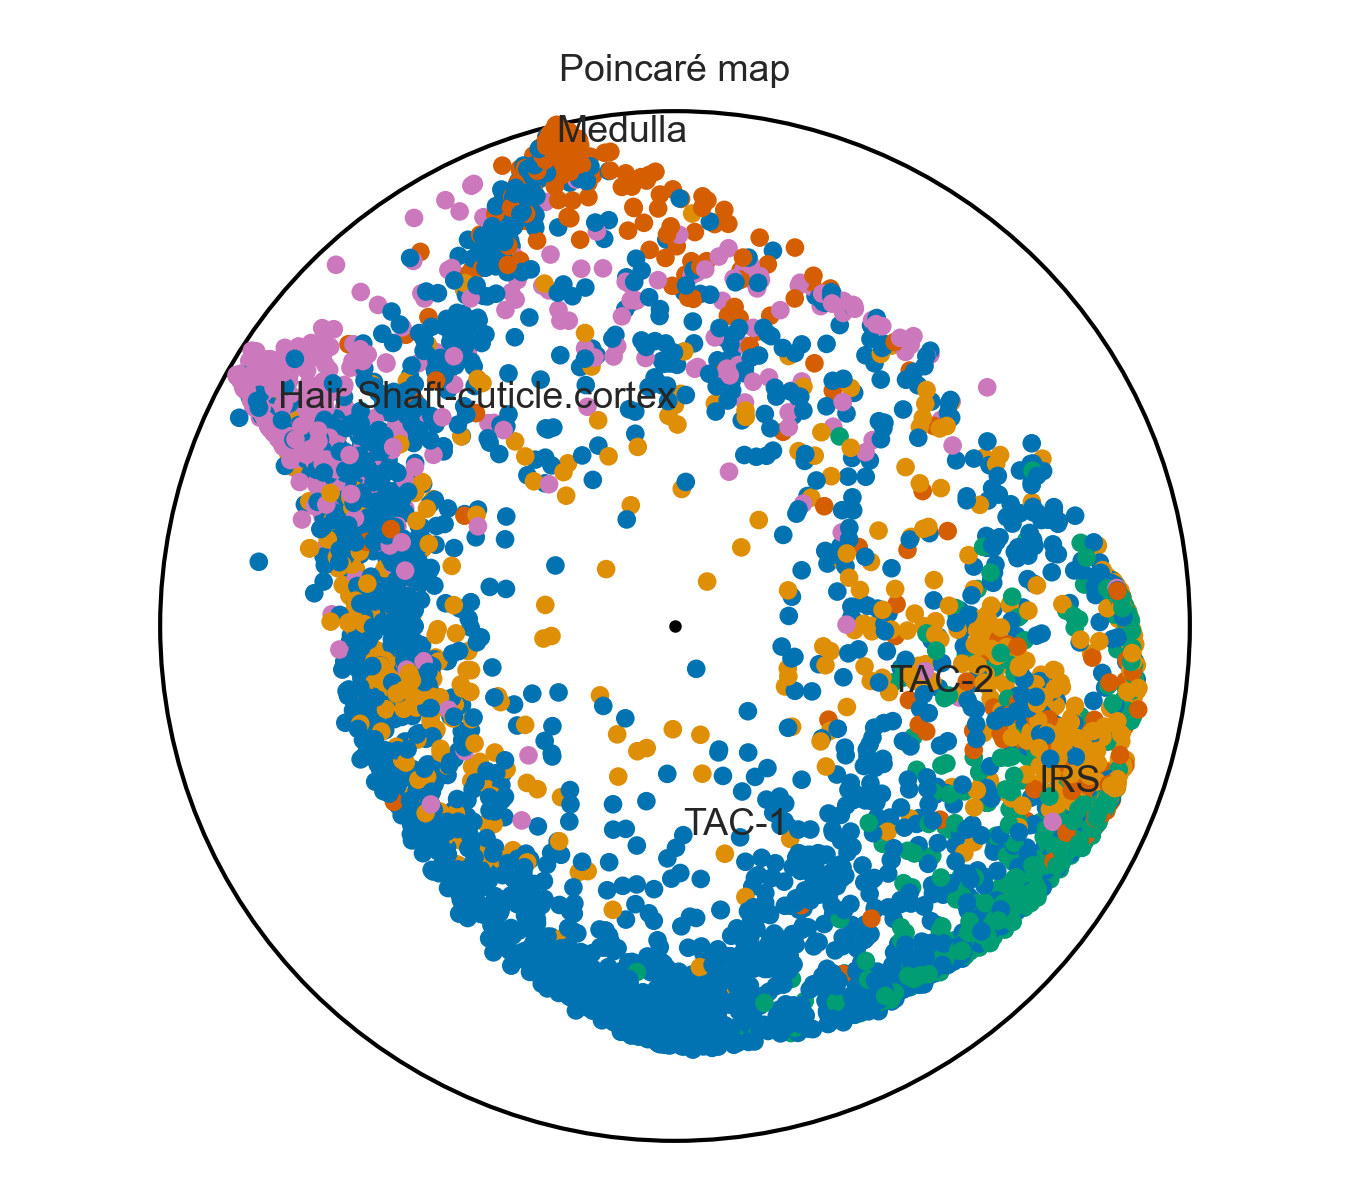

In [131]:
fig = Image(filename=f'{workdir}/atac_simba.celltype_label.poincare_coord.png')
fig


# SIMBA RNA + ATAC

In [113]:
simba_multi_fn = "../results/01/simba_CG_CP_adata_C.h5ad"
simba_multi_adata = sc.read_h5ad(simba_multi_fn)
simba_multi_df = pd.DataFrame(
    np.concatenate([simba_multi_adata.X, simba_multi_adata.obs['celltype'].values.reshape(-1, 1)], axis=1)
).rename(columns={simba_multi_adata.X.shape[1]: 'labels'})
simba_multi_df.head()


,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,labels
0,-0.368423,0.838683,-0.623168,-0.021646,-0.439905,-0.373646,-0.526403,-0.037842,-0.268041,-0.008901,...,0.117068,0.678845,-0.22639,0.309888,1.008031,-0.291178,-0.257829,-0.660494,-0.451875,TAC-1
1,-0.24592,-0.143892,0.176637,-0.194794,-0.04613,-0.059414,-0.008439,-0.064997,0.61272,0.625968,...,-0.03259,0.735982,-0.986562,1.007481,0.595117,0.304355,-0.110378,-0.05029,0.442949,TAC-1
2,-0.543879,-0.222704,-0.586802,0.55767,0.10486,-0.215785,-0.414049,-0.045343,0.883455,-0.003239,...,-0.425477,0.475078,-0.189254,0.75826,1.032211,-0.204414,-0.644451,-0.234316,-0.083495,TAC-2
3,-0.507449,-0.427839,-0.675932,-0.565183,-0.23381,-0.677991,-0.782332,0.313886,0.114418,0.30865,...,0.308921,0.411989,0.014248,0.237726,-0.493097,0.640361,-0.156039,-0.017912,-0.481386,Hair Shaft-cuticle.cortex
4,-0.140851,0.146819,-0.031019,0.403438,0.10092,-0.160864,-0.07866,0.250526,-0.427439,-0.22729,...,-0.170138,0.263716,-0.432529,0.741777,-0.142351,-0.078714,0.675566,-0.608233,0.738511,TAC-2


In [114]:
simba_multi_df_fn = f'{workdir}/multi_simba.celltype_label.csv'
print(simba_multi_df_fn)
simba_multi_df.to_csv(simba_multi_df_fn, index=False, sep=',')


../results/02/multi_simba.celltype_label.csv


In [115]:
simba_multi_features, simba_multi_labels = prepare_data(
    '../results/02/multi_simba.celltype_label', 
    with_labels=True, 
    normalize=True, 
    n_pca=0
)

In [116]:
simba_multi_poincare_coord, _ = compute_poincare_maps(simba_multi_features, simba_multi_labels,
                        f"{workdir}/multi_simba.celltype_label.poincare_coord",
                        mode='features', k_neighbours=15, 
                        distlocal='minkowski', sigma=1.0, gamma=2.0,
                        color_dict=celltype_colors, epochs=100,
                        batchsize=-1, lr=0.1, earlystop=0.0001, cuda=0)

Computing laplacian...
Laplacian computed in 3.15 sec
Computing RFA...
RFA computed in 4.75 sec
batchsize =  512
Starting training...


loss: 0.45850: 100%|██████████████████████████| 100/100 [17:17<00:00, 10.38s/it]


PM computed in 1037.60 sec
loss = 4.585e-01
time = 17.296 min


In [117]:
simba_multi_poincare_coord_df = pd.DataFrame(np.concatenate([simba_multi_poincare_coord, simba_multi_labels.reshape(-1, 1)], axis=1))
simba_multi_poincare_coord_df.columns = ['x', 'y', 'labels']
simba_multi_poincare_coord_df.head()

,x,y,labels
0,0.12360751705975397,-0.041736530224259036,TAC-1
1,-0.021337297017416636,-0.17847917697040622,TAC-1
2,-0.040962786682552155,-0.2738222756940346,TAC-2
3,0.10555503531738458,0.3020435591299188,Hair Shaft-cuticle.cortex
4,-0.07689695712745252,0.06301882427955954,TAC-2


In [118]:
simba_multi_poincare_coord_fn = f'{workdir}/multi_simba.celltype_label.poincare_coord.labeled.csv'
print(simba_multi_poincare_coord_fn)
simba_multi_poincare_coord_df.to_csv(simba_multi_poincare_coord_fn, index=False, sep=',')

../results/02/multi_simba.celltype_label.poincare_coord.labeled.csv


In [132]:
simba_multi_model = PoincareMaps(simba_multi_poincare_coord)

simba_multi_model.plot('ori', labels=simba_multi_labels, file_name='../results/02/multi_simba.celltype_label.poincare_coord', 
           title_name='Poincaré map', 
           coldict=celltype_colors, 
           labels_order=None, 
           zoom=2, bbox=(1.1, 0.8), leg=False, ft='png')

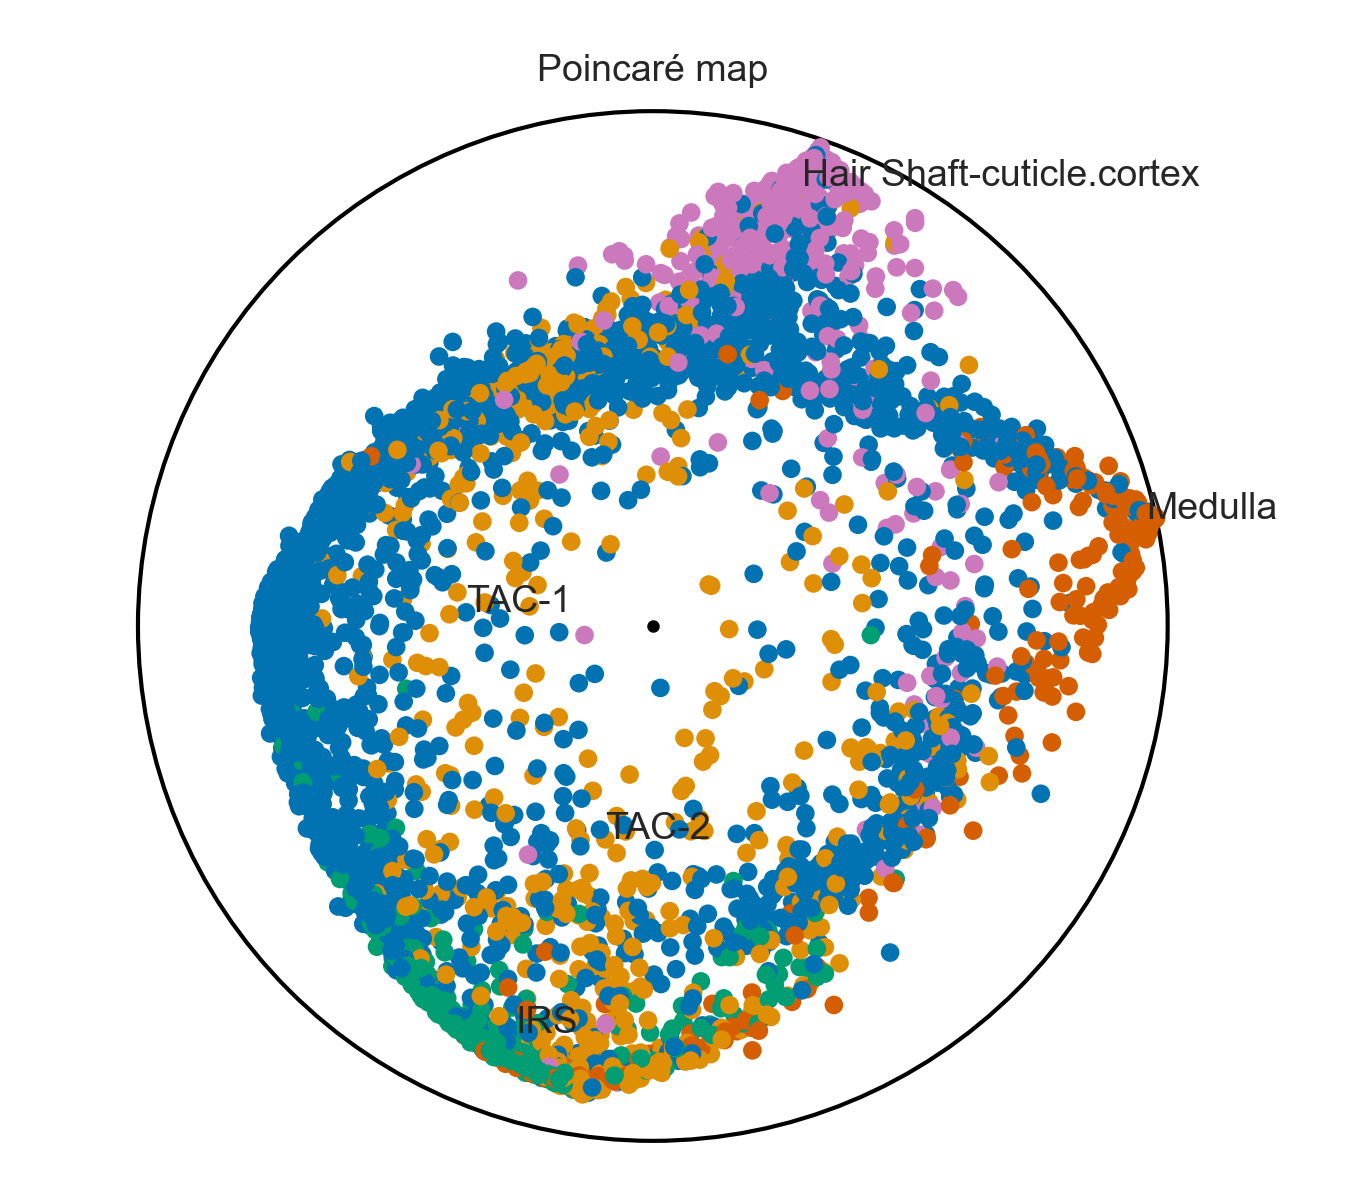

In [133]:
fig = Image(filename=f'{workdir}/multi_simba.celltype_label.poincare_coord.png')
fig
